In [38]:
import typing


class ParseNode:
    data = ""
    children: list[typing.Type["ParseNode"]]
    from_ = -1
    to_ = -1

    attrs = None

    def __init__(self, data) -> None:
        self.data = data
        self.children = []
        self.attrs = []
        pass

    def add_child(self, node: typing.Type["ParseNode"]):
        if not len(self.children):
            self.from_ = node.from_
        self.to_ = node.to_

        if node.data in ['<proxy>']:
            for ch in node.children:
                self.add_child(ch)
            return

        self.children.append(node)

    def print(self, tree=None, parent="", id="main"):
        from graphviz import Digraph
        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"
        tree.node(id, str(self.data) + "\n" + " ".join([str(x) for x in self.attrs]))
        if parent:
            tree.edge(parent, id)

        # print("IN:",  self.data, [ch.data for ch in self.children])
        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))
        # print("OUT:",  self.data, [ch.data for ch in self.children])

        return tree


def make_parse_lexem(lexem: str):
    def parse_lexem(lexems: typing.List[str], startPos: int):
        if startPos >= len(lexems):
            return None
        if lexems[startPos] == lexem:
            tree = ParseNode(lexem)
            tree.from_ = startPos
            tree.to_ = startPos + 1
            return tree
        return None
    return parse_lexem


def make_choice(rules):
    def combinator(lexems: typing.List[str], startPos: int):
        for rule in rules:
            node = rule(lexems, startPos)
            if not node:
                continue
            return node

        return None
    return combinator


def make_combine(rules, actions = None):
    def combinator(lexems: typing.List[str], startPos: int):
        tree = ParseNode('<proxy>')
        curPos = startPos
        for rule in rules:
            node = rule(lexems, curPos)
            if not node:
                return None

            tree.add_child(node)
            curPos = node.to_
        return tree

    def action_wrapper(lexems: typing.List[str], startPos: int):
        tree = combinator(lexems, startPos)
        if tree and actions:
            tree.attrs = actions(*tree.children)
        return tree

    return action_wrapper


def parse_mult_op(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_parse_lexem('*'),
        make_parse_lexem('!'),
        make_parse_lexem('mod'),
        make_parse_lexem('rem'),
    ])(lexems, startPos)
    if not tree:
        return None

    # tree.data = '<мультипликативная операция>'
    return tree


def parse_unar(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_parse_lexem('+'),
        make_parse_lexem('-'),
    ])(lexems, startPos)
    if not tree:
        return None

    # tree.data = '<унарная аддитивная операция>'
    return tree


def parse_bin_op(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_parse_lexem('+'),
        make_parse_lexem('-'),
        make_parse_lexem('&'),
    ])(lexems, startPos)
    if not tree:
        return None

    # tree.data = '<бинарная аддитивная операция>'
    return tree


def parse_rel_op(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_parse_lexem('<'),
        make_parse_lexem('<='),
        make_parse_lexem('='),
        make_parse_lexem('/>'),
        make_parse_lexem('>'),
        make_parse_lexem('>='),
    ])(lexems, startPos)
    if not tree:
        return None

    # tree.data = '<операция отношения>'
    return tree


def parse_log_op(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_parse_lexem('and'),
        make_parse_lexem('or'),
        make_parse_lexem('xor'),
    ])(lexems, startPos)
    if not tree:
        return None
    # tree.data = '<логическая операция>'
    return tree


def parse_id(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    if startPos >= len(lexems):
        return None
    tree = ParseNode("<имя>")

    data = lexems[startPos]
    if not data.isalpha():
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)

    tree.attrs = [data]
    return tree


def parse_num(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    if startPos >= len(lexems):
        return None

    tree = ParseNode("<числовой литерал>")

    try:
        data = float(lexems[startPos])
    except:
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    tree.attrs = [data]

    return tree


def parse_first(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_combine([
            make_parse_lexem('('),
            parse_expr,
            make_parse_lexem(')'),
        ], actions=lambda a,b,c: b.attrs),
        parse_id,
        parse_num,
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<первичное>'
    return tree


def parse_mnoz(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_combine([
            make_parse_lexem('abs'),
            parse_first,
        ], actions=lambda a, b: [a.data] + b.attrs),
        make_combine([
            make_parse_lexem('not'),
            parse_first,
        ], actions=lambda a, b: [a.data] + b.attrs ),
        make_combine([
            parse_first,
            make_parse_lexem('**'),
            parse_first
        ], actions=lambda a, b, c: [b.data] + a.attrs + c.attrs),
        parse_first
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<множитель>'
    return tree


def parse_slag(lexems: typing.List[str], startPos: int):
    tree = make_choice([
        make_combine([
            parse_mnoz,
            parse_mult_op,
            parse_slag
        ], actions=lambda a, b, c: [b.data] + a.attrs + c.attrs),
        parse_mnoz
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<слагаемое>'
    return tree

def parse_smpl_stmt2(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_combine([
            parse_slag,
            parse_bin_op,
            parse_smpl_stmt2
        ], actions=lambda a, b, c: [b.data] + a.attrs + c.attrs),
        parse_slag
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<простое выражение 2>'
    return tree

def parse_smpl_stmt(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice(
        [
            make_combine([
                parse_unar,
                parse_smpl_stmt2
            ], actions=lambda a, b: [a.data, 0] + b.attrs),
            parse_smpl_stmt2
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = '<простое выражение>'
    return tree


def parse_rel(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:

    tree = make_choice(
        [
            make_combine([
                parse_smpl_stmt,
                parse_rel_op,
                parse_rel
            ], actions=lambda a, b, c: [b.data] + a.attrs + c.attrs),
            parse_smpl_stmt
        ]
    )(lexems, startPos)
    if not tree:
        return None
    tree.data = '<отношение>'
    return tree


def parse_expr(lexems: typing.List[str], startPos: int) -> typing.Optional[ParseNode]:
    tree = make_choice(
        [
            make_combine([
                parse_rel,
                parse_log_op,
                parse_expr
            ], actions=lambda rel, logop, expr: logop.data + rel.attrs + expr.attrs),
            parse_rel
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<выражение>"

    return tree

['-', '5', '+', '5', '+', '7', '**', '9', '-', 'abs', '(', '14', '+', '12', ')', '>', '20']


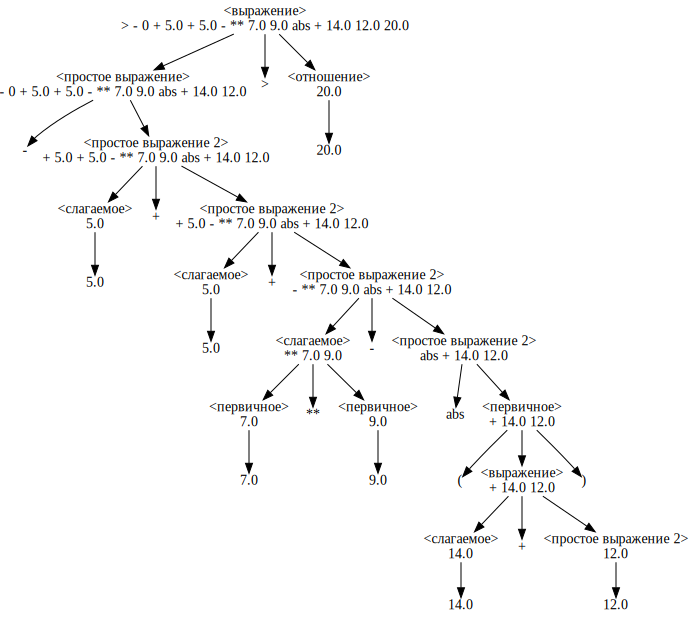

In [54]:

def tokenize(code: str):
    tokens = []
    curPos = 0
    while curPos < len(code):
        if code[curPos: min(curPos + 2, len(code))] in ['**', '<=', '>=', '/>']:
            tokens += [code[curPos: min(curPos + 2, len(code))]]
            curPos += 2
        elif code[curPos] in ['+', '-', '*', '/', '>', '<', '=', '&', '(', ')', '{', '}', ';']:
            tokens += [code[curPos]]
            curPos += 1
        elif code[curPos] in [' ', '\t' ,'\n', '\r']:
            curPos += 1
        else:
            startpos = curPos
            while curPos < len(code) and (code[curPos].isalpha() or code[curPos].isnumeric() or code[curPos] in ["_", '.']):
                curPos += 1
            tokens += [code[startpos: curPos]]
            if (startpos == curPos):
                print("ERROR")
                break
        # print(tokens[-1])
    return tokens

code = "-5+5+7**9 - abs(14 + 12) > 20"
print(tokenize(code))
tree = parse_expr(tokenize(code), 0)
display(tree.print())


In [53]:
def test(id_d, out_d):
      tree = parse_expr(tokenize(id_d), 0)
      res = " ".join(map(str,tree.attrs))
      return "|" + id_d + "|" + out_d + "|" + res + "|" + str(out_d == res) + "|"

tests = [
      (
            "a+b",
            "+ a b"
      ),
      (
            "-a+b",
            "- 0 + a b"
      ),
      (
            "a - b * c",
            "- a * b c"
      ),
      (
            "a > b * c",
            "> a * b c"
      ),
      (
            "abs(a + b) > z",
            "> abs + a b z"
      ),
      (
            "a + b + c * d - e",
            "+ a + b - * c d e"
      ),

      (
            "a + (b + c) * d - e",
            "+ a - * + b c d e"
      ),
]

import IPython
IPython.display.Markdown("|IN|WAIT|RES|OK?|\n|---|---|---|---|\n" + "\n".join(list(map(lambda x: test(x[0], x[1]), tests))))



|IN|WAIT|RES|OK?|
|---|---|---|---|
|a+b|+ a b|+ a b|True|
|-a+b|- 0 + a b|- 0 + a b|True|
|a - b * c|- a * b c|- a * b c|True|
|a > b * c|> a * b c|> a * b c|True|
|abs(a + b) > z|> abs + a b z|> abs + a b z|True|
|a + b + c * d - e|+ a + b - * c d e|+ a + b - * c d e|True|
|a + (b + c) * d - e|+ a - * + b c d e|+ a - * + b c d e|True|